In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Path dataset yang benar 
BASE_PATH = '/kaggle/input/car-vs-bike-classification-dataset/Car-Bike-Dataset'

Struktur dataset:
['Car', 'Bike']

Jumlah gambar:
- Bike: 2000 gambar
- Car: 2000 gambar


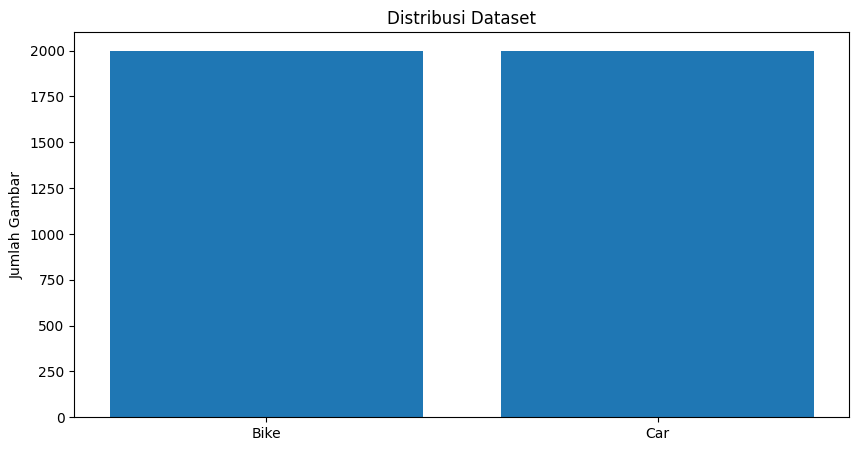

In [10]:
def check_dataset():
    print("Struktur dataset:")
    print(os.listdir(BASE_PATH))
    
    bike_path = os.path.join(BASE_PATH, 'Bike')
    car_path = os.path.join(BASE_PATH, 'Car')
    
    print("\nJumlah gambar:")
    print(f"- Bike: {len(os.listdir(bike_path))} gambar")
    print(f"- Car: {len(os.listdir(car_path))} gambar")
    
    # Cek distribusi gambar
    plt.figure(figsize=(10,5))
    plt.bar(['Bike', 'Car'], [len(os.listdir(bike_path)), len(os.listdir(car_path))])
    plt.title('Distribusi Dataset')
    plt.ylabel('Jumlah Gambar')
    plt.show()

check_dataset()

In [11]:
# Untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% untuk validasi
)

train_generator = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['Bike', 'Car'],
    subset='training'
)

# Untuk data validasi
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_generator = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['Bike', 'Car'],
    subset='validation'
)

print("Daftar kelas:", train_generator.class_indices)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Daftar kelas: {'Bike': 0, 'Car': 1}


In [12]:
def create_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Buat model baru
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

model = create_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 429ms/step - accuracy: 0.9104 - loss: 0.1953 - val_accuracy: 0.9850 - val_loss: 0.0345
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 393ms/step - accuracy: 0.9773 - loss: 0.0692 - val_accuracy: 0.9912 - val_loss: 0.0402
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 393ms/step - accuracy: 0.9801 - loss: 0.0562 - val_accuracy: 0.9912 - val_loss: 0.0233
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 393ms/step - accuracy: 0.9833 - loss: 0.0505 - val_accuracy: 0.9937 - val_loss: 0.0232
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 394ms/step - accuracy: 0.9856 - loss: 0.0494 - val_accuracy: 0.9875 - val_loss: 0.0310
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 389ms/step - accuracy: 0.9846 - loss: 0.0436 - val_accuracy: 0.9912 - val_loss: 0.0220
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 392ms/step - accuracy: 0.9902 - loss: 0.0307 - val_accuracy: 0.9850 - val_loss: 0.0360
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 388ms/step - accuracy: 0.9864 - loss: 0

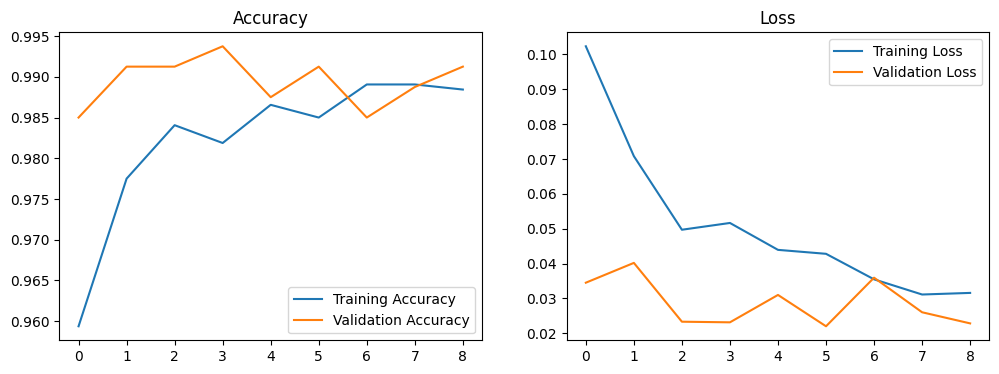

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9962 - loss: 0.0123
Validation Accuracy: 0.99
Validation Loss: 0.02


In [14]:
def plot_history(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_history(history)

# Evaluasi metrik
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {accuracy:.2f}')
print(f'Validation Loss: {loss:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


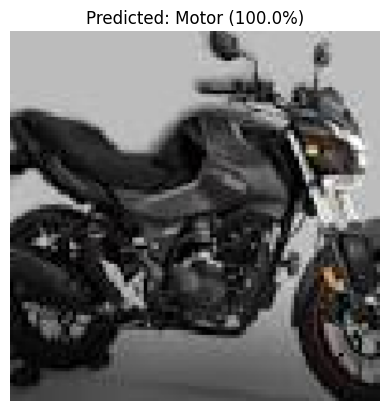

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


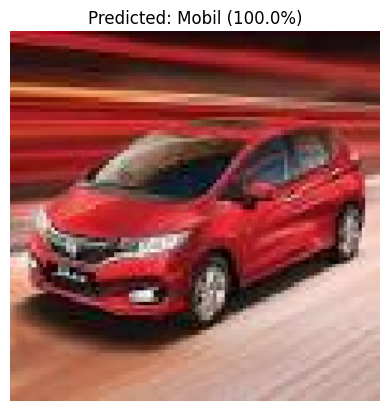

In [15]:
# Fungsi prediksi gambar
def predict_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)/255.0
    img_array = tf.expand_dims(img_array, 0)
    
    pred = model.predict(img_array)
    class_label = "Motor" if pred < 0.5 else "Mobil"
    confidence = pred[0][0] if pred >=0.5 else 1-pred[0][0]
    
    plt.imshow(img)
    plt.title(f"Predicted: {class_label} ({confidence:.1%})")
    plt.axis('off')
    plt.show()
    
# Contoh prediksi
test_bike = '/kaggle/input/car-vs-bike-classification-dataset/Car-Bike-Dataset/Bike/Bike (1).jpeg'
test_car = '/kaggle/input/car-vs-bike-classification-dataset/Car-Bike-Dataset/Car/Car (1).jpeg'

predict_image(test_bike)
predict_image(test_car)

In [16]:
# Simpan model lengkap
model.save('motor_vs_mobil_model.h5')

# Simpan model dalam format TF Lite (untuk mobile)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('motor_mobil.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil diexport!")

Saved artifact at '/tmp/tmpjenmkacb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_314')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135452255799440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135453048330128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135453048329936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135453048337616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135453048331280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135453048328592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450122352976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450122340112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135453048331664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135450122354128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1354501223

W0000 00:00:1752509746.164779      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752509746.164814      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1752509746.302685      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
